In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [10]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_1 = Add()([features_1, embedding_dropout])
features_2 = one_by_one(filtersNumber, features_1)
features_2 = Add()([features_2, features_1])
features_3 = one_by_one(filtersNumber, features_2)
features_3 = Add()([features_3, features_2])

features_4 = one_by_one(filtersNumber, features_3)
features_4 = Add()([features_4, features_3])
features_5 = one_by_one(filtersNumber, features_4)
features_5 = Add()([features_5, features_4])
features_6 = one_by_one(filtersNumber, features_5)
features_6 = Add()([features_6, features_5])

features_7 = one_by_one(filtersNumber, features_6)
features_7 = Add()([features_7, features_6])
features_8 = one_by_one(filtersNumber, features_7)
features_8 = Add()([features_8, features_7])
features_9 = one_by_one(filtersNumber, features_8)
features_9 = Add()([features_9, features_8])

features_10 = one_by_one(filtersNumber, features_9)
features_10 = Add()([features_10, features_9])
features_11 = one_by_one(filtersNumber, features_10)
features_11 = Add()([features_11, features_10])
features_12 = one_by_one(filtersNumber, features_11)
features_12 = Add()([features_12, features_11])

features = yoon_kim_feature_extractor(filtersNumber, features_12)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________

In [11]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 12:16 - loss: 0.1820 - acc: 0.9293

102112/102124 [============================>.] - ETA: 0s - loss: 0.0913 - acc: 0.9663

102124/102124 [==============================] - 975s 10ms/step - loss: 0.0913 - acc: 0.9663 - val_loss: 0.0509 - val_acc: 0.9814
Epoch 2/32
 10112/102124 [=>............................] - ETA: 13:32 - loss: 0.0612 - acc: 0.9778

102112/102124 [============================>.] - ETA: 0s - loss: 0.0592 - acc: 0.9785

102124/102124 [==============================] - 971s 10ms/step - loss: 0.0593 - acc: 0.9785 - val_loss: 0.0475 - val_acc: 0.9819
roc-auc: 0.9777 - roc-auc_val: 0.9754                                                                                                    
Epoch 3/32
  8672/102124 [=>............................] - ETA: 13:46 - loss: 0.0579 - acc: 0.9791

102112/102124 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9801

102124/102124 [==============================] - 972s 10ms/step - loss: 0.0538 - acc: 0.9801 - val_loss: 0.0458 - val_acc: 0.9827
Epoch 4/32
 10112/102124 [=>............................] - ETA: 13:34 - loss: 0.0511 - acc: 0.9806

102112/102124 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9811

102124/102124 [==============================] - 972s 10ms/step - loss: 0.0508 - acc: 0.9811 - val_loss: 0.0451 - val_acc: 0.9829
roc-auc: 0.9827 - roc-auc_val: 0.9806                                                                                                    
Epoch 5/32
  8672/102124 [=>............................] - ETA: 13:46 - loss: 0.0488 - acc: 0.9811

102112/102124 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9815

102124/102124 [==============================] - 971s 10ms/step - loss: 0.0486 - acc: 0.9815 - val_loss: 0.0430 - val_acc: 0.9834
Epoch 6/32
 10112/102124 [=>............................] - ETA: 13:34 - loss: 0.0454 - acc: 0.9825

102112/102124 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9821

102124/102124 [==============================] - 972s 10ms/step - loss: 0.0473 - acc: 0.9821 - val_loss: 0.0427 - val_acc: 0.9838
roc-auc: 0.9867 - roc-auc_val: 0.9832                                                                                                    
Epoch 7/32
  8672/102124 [=>............................] - ETA: 13:47 - loss: 0.0462 - acc: 0.9820

102112/102124 [============================>.] - ETA: 0s - loss: 0.0461 - acc: 0.9824

102124/102124 [==============================] - 971s 10ms/step - loss: 0.0461 - acc: 0.9824 - val_loss: 0.0423 - val_acc: 0.9838
Epoch 8/32
 10112/102124 [=>............................] - ETA: 13:33 - loss: 0.0454 - acc: 0.9829

102112/102124 [============================>.] - ETA: 0s - loss: 0.0451 - acc: 0.9828

102124/102124 [==============================] - 968s 9ms/step - loss: 0.0451 - acc: 0.9828 - val_loss: 0.0429 - val_acc: 0.9839
roc-auc: 0.9887 - roc-auc_val: 0.9845                                                                                                    
Epoch 9/32
  8672/102124 [=>............................] - ETA: 13:41 - loss: 0.0450 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9831

102124/102124 [==============================] - 970s 10ms/step - loss: 0.0441 - acc: 0.9830 - val_loss: 0.0411 - val_acc: 0.9842
Epoch 10/32
 10080/102124 [=>............................] - ETA: 13:33 - loss: 0.0443 - acc: 0.9829

102112/102124 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9831

102124/102124 [==============================] - 971s 10ms/step - loss: 0.0431 - acc: 0.9831 - val_loss: 0.0436 - val_acc: 0.9842
roc-auc: 0.9903 - roc-auc_val: 0.986                                                                                                    
Epoch 11/32
  8672/102124 [=>............................] - ETA: 13:46 - loss: 0.0403 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9836

102124/102124 [==============================] - 972s 10ms/step - loss: 0.0423 - acc: 0.9836 - val_loss: 0.0417 - val_acc: 0.9843

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00017677669529803097.
Epoch 12/32
  7968/102124 [=>............................] - ETA: 13:53 - loss: 0.0409 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9839

102124/102124 [==============================] - 969s 9ms/step - loss: 0.0412 - acc: 0.9839 - val_loss: 0.0427 - val_acc: 0.9845
roc-auc: 0.9919 - roc-auc_val: 0.9868                                                                                                    
Epoch 13/32
  8672/102124 [=>............................] - ETA: 13:45 - loss: 0.0434 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9839

102124/102124 [==============================] - 971s 10ms/step - loss: 0.0410 - acc: 0.9839 - val_loss: 0.0422 - val_acc: 0.9844
Epoch 14/32
 10080/102124 [=>............................] - ETA: 13:30 - loss: 0.0403 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9843

102124/102124 [==============================] - 967s 9ms/step - loss: 0.0402 - acc: 0.9843 - val_loss: 0.0433 - val_acc: 0.9845
roc-auc: 0.9927 - roc-auc_val: 0.9869                                                                                                    
Epoch 15/32
  8672/102124 [=>............................] - ETA: 13:45 - loss: 0.0387 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9843

102124/102124 [==============================] - 970s 10ms/step - loss: 0.0397 - acc: 0.9843 - val_loss: 0.0403 - val_acc: 0.9848
Epoch 16/32
 10080/102124 [=>............................] - ETA: 13:31 - loss: 0.0400 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9845

102124/102124 [==============================] - 970s 10ms/step - loss: 0.0390 - acc: 0.9845 - val_loss: 0.0409 - val_acc: 0.9846
roc-auc: 0.9934 - roc-auc_val: 0.9867                                                                                                    
Epoch 17/32
  8640/102124 [=>............................] - ETA: 13:43 - loss: 0.0380 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9847

102124/102124 [==============================] - 970s 9ms/step - loss: 0.0386 - acc: 0.9847 - val_loss: 0.0411 - val_acc: 0.9847
Epoch 18/32
 10112/102124 [=>............................] - ETA: 13:34 - loss: 0.0376 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9848

102124/102124 [==============================] - 971s 10ms/step - loss: 0.0381 - acc: 0.9848 - val_loss: 0.0406 - val_acc: 0.9848
roc-auc: 0.9939 - roc-auc_val: 0.987                                                                                                    
Epoch 19/32
  8672/102124 [=>............................] - ETA: 13:45 - loss: 0.0397 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9850

102124/102124 [==============================] - 969s 9ms/step - loss: 0.0375 - acc: 0.9850 - val_loss: 0.0406 - val_acc: 0.9846
Epoch 20/32
 10112/102124 [=>............................] - ETA: 13:31 - loss: 0.0374 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9851

102124/102124 [==============================] - 968s 9ms/step - loss: 0.0373 - acc: 0.9851 - val_loss: 0.0408 - val_acc: 0.9848
roc-auc: 0.9939 - roc-auc_val: 0.9871                                                                                                    
Epoch 21/32
  8672/102124 [=>............................] - ETA: 13:43 - loss: 0.0377 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0370 - acc: 0.9851

102124/102124 [==============================] - 967s 9ms/step - loss: 0.0370 - acc: 0.9851 - val_loss: 0.0404 - val_acc: 0.9848
Epoch 22/32
 10112/102124 [=>............................] - ETA: 13:35 - loss: 0.0359 - acc: 0.9856

102112/102124 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9854

102124/102124 [==============================] - 974s 10ms/step - loss: 0.0366 - acc: 0.9854 - val_loss: 0.0413 - val_acc: 0.9846

Epoch 00022: ReduceLROnPlateau reducing learning rate to 5.632815373246558e-05.
roc-auc: 0.9946 - roc-auc_val: 0.9873                                                                                                    
Epoch 23/32
  5920/102124 [>.............................] - ETA: 14:12 - loss: 0.0346 - acc: 0.9856

102112/102124 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9854

102124/102124 [==============================] - 970s 10ms/step - loss: 0.0363 - acc: 0.9854 - val_loss: 0.0410 - val_acc: 0.9846
Epoch 24/32
 10080/102124 [=>............................] - ETA: 13:31 - loss: 0.0377 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0361 - acc: 0.9854

102124/102124 [==============================] - 969s 9ms/step - loss: 0.0361 - acc: 0.9854 - val_loss: 0.0412 - val_acc: 0.9846
roc-auc: 0.9948 - roc-auc_val: 0.9872                                                                                                    
Epoch 25/32
  8672/102124 [=>............................] - ETA: 13:43 - loss: 0.0361 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9856

102124/102124 [==============================] - 967s 9ms/step - loss: 0.0356 - acc: 0.9856 - val_loss: 0.0411 - val_acc: 0.9846


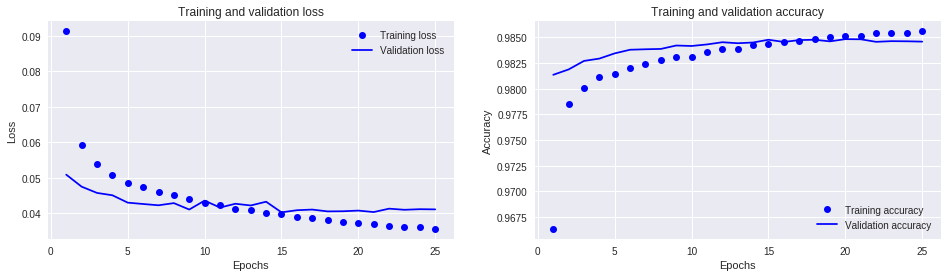

In [12]:
plot_history(history)

In [13]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 90s 3ms/step
([0.03880784052800426, 0.9851219243228613], 0.9891372617508941)
